# Lab 3

Noah Kim

Section AC

### Problem 1

For the experiment to work reliably, the temperature should be at around 12 Kelvin, and if we look at the data it is mostly consistent with 12 Kelvin to within the 0.4 degree precision of the thermometry and the thermal control system (standard deviation). However, I recorded some bad readings for the temperature of values:  {10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7}. My goal is to throw out these values

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=22)
matplotlib.rc('figure', figsize=(18, 10))
import numpy as np
import pandas as pd
from scipy import stats, signal

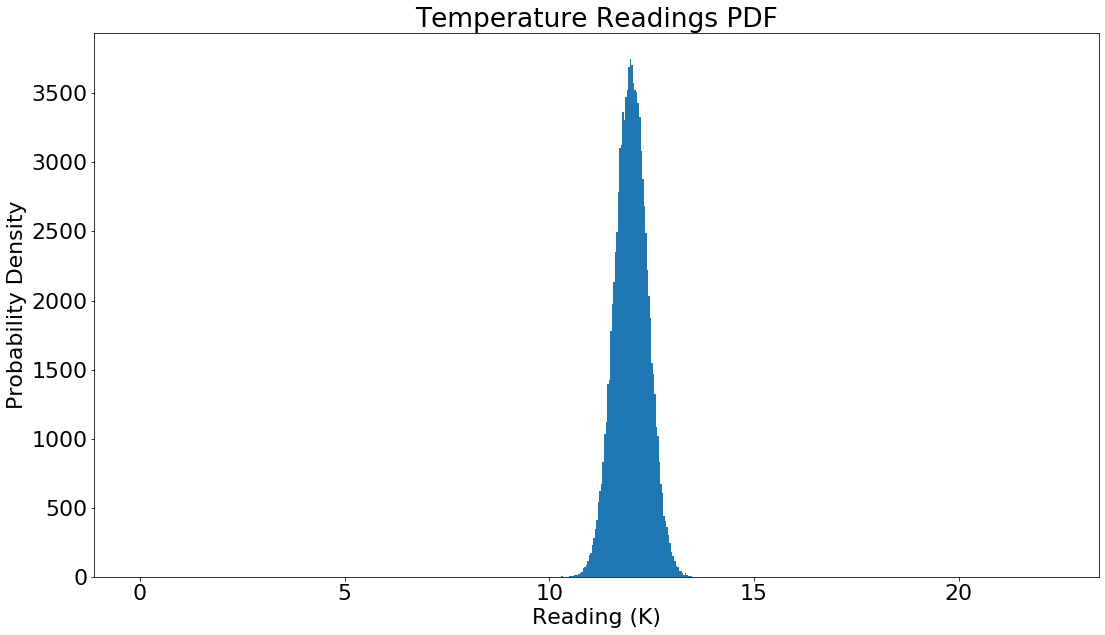

In [187]:
mean, sd = 12, 0.4
good_readings = stats.norm(mean, sd).rvs(100000)
bad_readings = np.array([10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7])
readings = np.concatenate((good_readings, bad_readings))
plt.title('Temperature Readings PDF');
plt.xlabel('Reading (K)');
plt.ylabel('Probability Density');
plt.hist(readings, bins= 600);


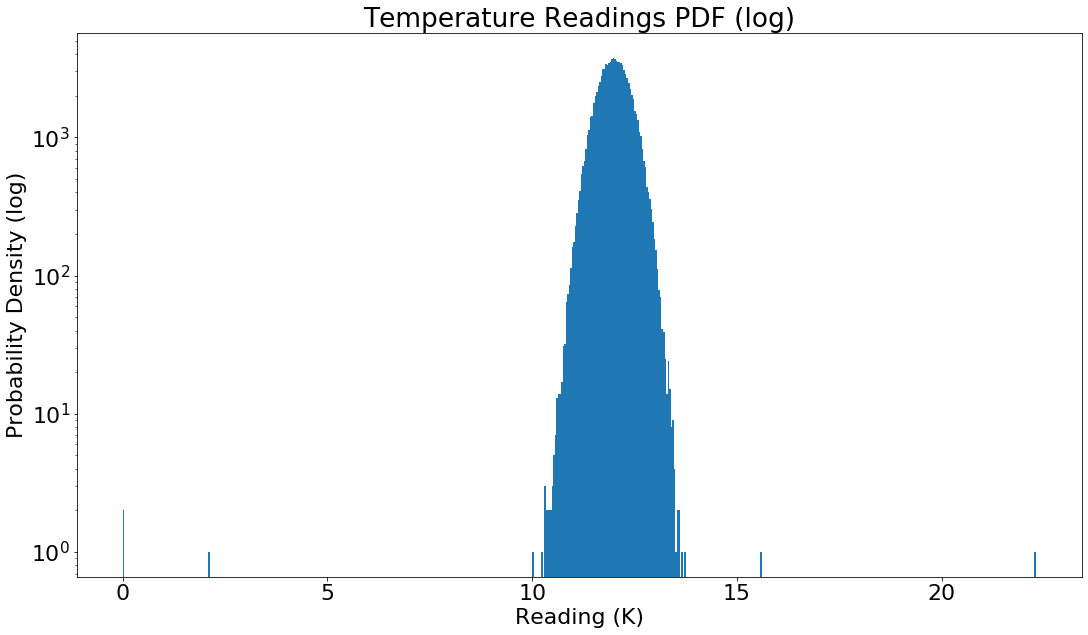

In [188]:
plt.yscale('log');
plt.hist(readings, bins= 600);
plt.title('Temperature Readings PDF (log)');
plt.xlabel('Reading (K)');
plt.ylabel('Probability Density (log)');

**2. State the statistical question in words. Be very clear, and describe why you have chosen this statistical question.**

What is the probability that the temperature data is a probability of 5-sigma above or below the average of 12 Kelvin, what is the probability of 3-sigma? 1-sigma?. I chose this statistical question to show the extend of my algorithm throwing out bad data and possible good data and show possible flaws since my goal is to toss out all the bad values. 

**3. Restate your questin in math. Be very clear.**

The 5 sigma point is representative of a an extremely rare event where as the 3 sigma is much more common than 5, and so on for 1 sigma, For our distribution we want to find the equivalent of 5, 3, and 1 sigma probability, and identify where these probability temperature values lie in my distribution. I will be identifying the range of valid temperature readings that my data will accept -5, 3, -1 and 5, 3, 1 of values in these sigma ranges. While tossing all outliers below and above these sigma probability points.

In [133]:
def get_counts(sigma):
    true_kept = good_readings[np.where((good_readings < 12 + sigma * 0.4) & (good_readings > 12 - sigma * 0.4))]
    true_discarded = len(good_readings) - len(true_kept)

    badkept = bad_readings[np.where((bad_readings > 12 - sigma * 0.4) & (bad_readings < 12 + sigma * 0.4))]
    bad_discarded = len(bad_readings) - len(badkept)
    truth_table = pd.DataFrame(np.array([[len(true_kept),len(badkept)],[true_discarded,bad_discarded]]),index = ['Kept','Discarded'], columns=['Good Data', 'Bad Data'])
    print(truth_table)

get_counts(1)
get_counts(3)
get_counts(5)

           Good Data  Bad Data
Kept           68225         0
Discarded      31775         8
           Good Data  Bad Data
Kept           99743         1
Discarded        257         7
           Good Data  Bad Data
Kept          100000         2
Discarded          0         6


**B) How does the number of omissions, where you threw out good data, depend on the statistical threshold you chose and is it a predictable quantity?**

The number of omissions depends on the statistical threshold I chose. The lower the threshold the more good data was thrown out. This is a predictable quantity because the algorithm I created discards maintains a value with a small range. For example, the 1 sigma has a much smaller range than the sigma 5. This makes it so the condition to be kept is much tighter than you would for 5 sigma. The truth table shows that above. In this case any value that was greater than 12.4 and lower than 11.6 was discarded. Where as in the case for 5 sigma any values below 10 and above 14 were discarded. This is a very predictable quantity. 

**C) Are there mistakes of commission (bad data getting in)? If yes, are they avoidable and how do they depend on your statistical threshold?**

Yes there are mistakes of commission seen in the higher sigma values. They are avoidable but they are at the cost of throwing out many good data points as well. It depends on the threshold value where the more lenient it is (say with 5 sigma) the number of bad data that is kept also increases as they fill within that threshold amount. The tighter the threshold the harder it is for the bad data to be kept, however, some values for the good data are thrown out.

### Problem 2

In this example we will be looking for asteroids. If we look at the alignment of stars on subsequent images, they don't perfectly align due to atmospheric and instrumental effects (even ignoring proper motion). The resulting distribution is two dimensional, and for this lab let's assume it is a 2D Gaussian with 1 arcsecond RMS. Or said another way, if I histogram how far all the (stationary) stars appear to have moved I get something like:

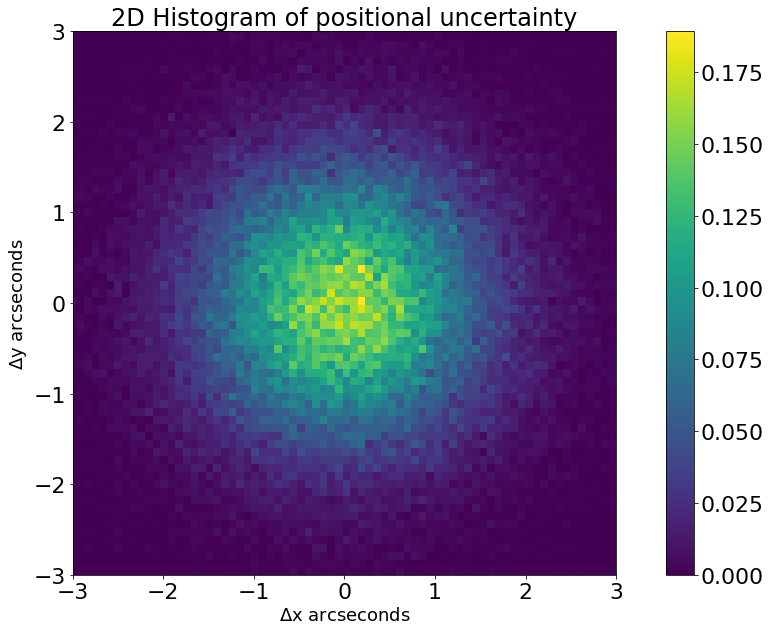

In [126]:
a = np.vstack((stats.norm.rvs( scale = 1, size = 100000), stats.norm.rvs( scale = 1, size = 100000)))
a.shape
fig, ax = plt.subplots(1, 1)
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);
ax.set_aspect('equal', 'box')
plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.title("2D Histogram of positional uncertainty", fontsize = 24)
plt.ylabel("$\Delta$y arcseconds", fontsize = 18)
plt.xlabel("$\Delta$x arcseconds", fontsize = 18)
plt.colorbar(h[3], ax=ax)

**If I have a potential asteroid, it will have some true movement between the images. We would like a '5 sigma' detection of movement. What is that distance in arcseconds?**

In order to answer this question, I need to know how far the asteriod is before I can determine whether or not the asteriod has a 5$\sigma$ significance. In order to find this threshold, I need to ask myself: What distance away from the origin where the 2D Gaussian background might produce a position that has a significance of 5$\sigma$ 

I first calculated the probability of having a 5$\sigma$ significance for a normal gaussian distribution:

In [135]:
prob = 1 - stats.norm.cdf(5)
print('Probability of getting a 5 sigma detection: ', prob)

Probability of getting a 5 sigma detection:  2.866515719235352e-07


Traditionally in order to find the corresponding value for a significance we used the ppf function but with a 2D Gaussian function the standard stats.norm.ppf does not work instead I need to find a distribution that most closely resembles the 2D Gaussian. The 2D Gaussian distribution has a Gaussian distribution in both the X and Y axes (Horizontal and Vertical movement) in order to create the image above. Since each distribution is independent I can solve for movement as: $M = \sqrt{X^2 + Y^2}$. After doing some research, I found the root mean square of two gaussian distributions for two variables is the Rayleigh's distribution. Therefore, I can solve for the Distance for a significance of $5\sigma$. Mathematically this is the integral from $5$ to $\infty$ of the PDF of the Rayleigh's distribution to find the probability of having a significance of $5\sigma$ and then the ppf function in order to find the distance associated with that probability.

In [138]:
distance = stats.rayleigh.ppf(1- prob)
print(distance, 'arcseconds')

5.489079776034238 arcseconds


The associated threshold value to have a significance of $5\sigma$ is approximately 5.49 arcseconds.

### Problem 3

We know from class that the Cosmic rays follow a Poisson distribution. Assuming that a moon sized patch on the sky normally emits 1 cosmic ray per minute and we observe the moon for 8 hours per night for 15 days. Calculating what averages I would get, I would have $60$ cosmic rays in an hour and over a period of 8 hours a day that means I would of seen $60 * 8$ so around $480$ cosmic rays in one night. So the mean of a single day of my Poisson distribution would be at $480$. Now since I am doing this over a period of 15 days. $480 * 15$ and this is equal to $7200$ cosmic rays in the period of 15 days. I am able to multiply the Poisson distribution here by the number of days because convolving the Poisson distribution is the same Poisson distribution with the mean equal to the sum of all the means of the convolved distribution. Since all the Poisson distributions have a mean of 480 I can multiply it by 15.

Now to visualize what the distribution would look like:

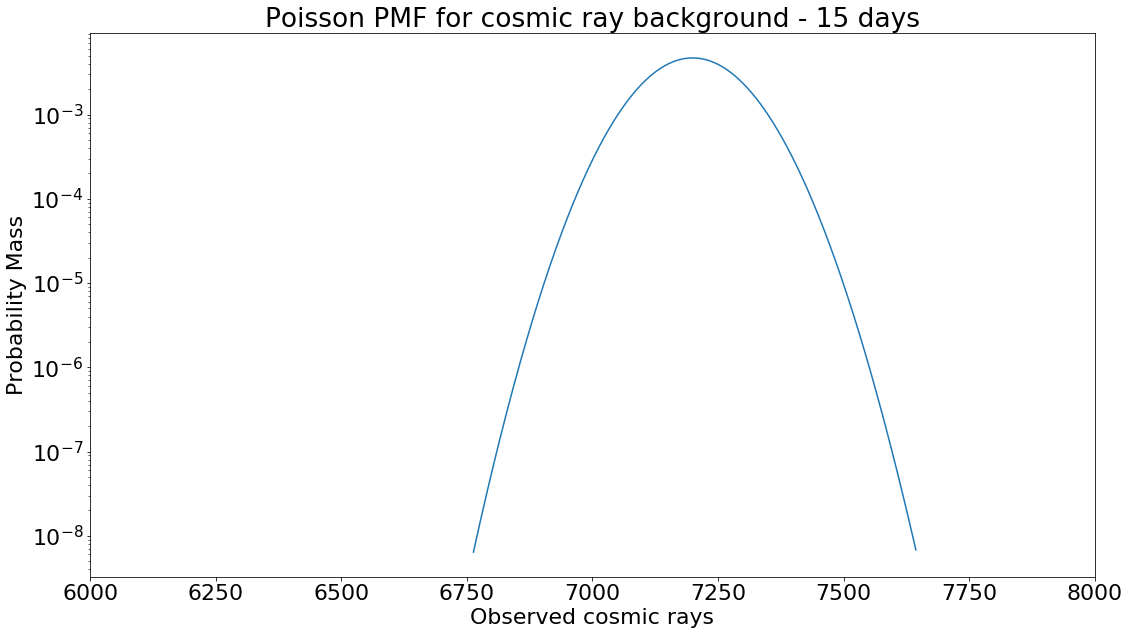

In [181]:
x = np.arange(stats.poisson.ppf(0.0000001, 7200), stats.poisson.ppf(0.9999999, 7200))
pmf = stats.poisson.pmf(x, 7200)
plt.yscale('log')
plt.xlim([6000,8000])
plt.title("Poisson PMF for cosmic ray background for 15 days")
plt.xlabel("Observed cosmic rays")
plt.ylabel("Probability Mass")
plt.plot(x, pmf);

When plotting the probability mass function using a logarithmic y-scale, the plot seems to be Gaussian by the shape of the downwards parabola. We learned before that the larger mean the more the Poisson distribution will approach a Gaussian Distribution. 

Now we want to see the significance of seeing 6800 cosmic rays over a span of 15 days. which is asking the question: What is the probability of the background data having a values less than or equal to 6800 cosmic rays in 15 days?

In order to answer this question I would have to take the integral of the background from 0 to 6800 using the cdf function of a poisson distribution where the mean is 7200 and the value I want is 6800. Below is the probability I would get if I integrated from 0 to 6800:

In [194]:
prob =stats.poisson.cdf(6800,7200)
print(prob)

1.0133280183917768e-06


In most of the previous cases we have done with homework and labs we usually integrated from a certain value to infinity. This has been the case where we would have prob = 1 - stats.distribution.cdf and sigma = stats.norm.ppf(1-prob). However, this case is quite unique in the sense that we do not take the integral from 6800 to infinity rather the integral from 0 to 6800. This is because of the definition of being "more signal-like" because when we have less cosmic rays than expected we assume there is an object blocking the rays causing us to miss some. So in this case when we see less cosmic rays it corresponds with having more signal. Since we make this distinction, the way to calculate the significance is to take the integral from 0 to 6800 vs. 6800 to infinity.

In [193]:
sigma = stats.norm.ppf(prob)
print(sigma)

-4.750747965777188


The significance of the moon shadow detection is $4.75\sigma$ the negative indicating it is on the left side of the mean.